# Identify genes most associated with ageing

In [45]:
import scanpy as sc
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad('../data/visum_aging_brain.h5ad')

In [10]:
adata.obs.age_group.unique()

['Old', 'Mid', 'Young']
Categories (3, object): ['Mid', 'Old', 'Young']

In [11]:
mapping = {
    'Young':6,
    'Mid':18,
    'Old':21,
}

In [12]:
adata.obs['age_months'] = adata.obs.age_group.map(mapping)

In [13]:
# Example: pseudobulk per sample (all spots together)
pb = adata.to_df().groupby(adata.obs["sample"]).mean()

ages = adata.obs.groupby("sample")["age_months"].first()
X = sm.add_constant(ages)

results = []
for g in pb.columns:
    y = pb[g].values
    model = sm.OLS(y, X).fit()
    slope = model.params["age_months"]
    pval  = model.pvalues["age_months"]
    results.append((g, slope, pval))

res_df = pd.DataFrame(results, columns=["gene","slope","pval"]).sort_values("pval")

In [18]:
res_df.sort_values(by = 'slope', ascending = False).head(50)

,gene,slope,pval
32284,AC149090.1,0.038346,0.004831
27851,C4b,0.025767,0.002591
29544,Neat1,0.021040,0.001297
11882,Tyrobp,0.017046,0.000685
20327,Gfap,0.016546,0.030388
30425,Rbm3,0.016320,0.023552
7086,C1qa,0.015167,0.004822
7084,C1qb,0.014962,0.009373
5016,Ctss,0.014556,0.013799
18367,Lyz2,0.013792,0.012164


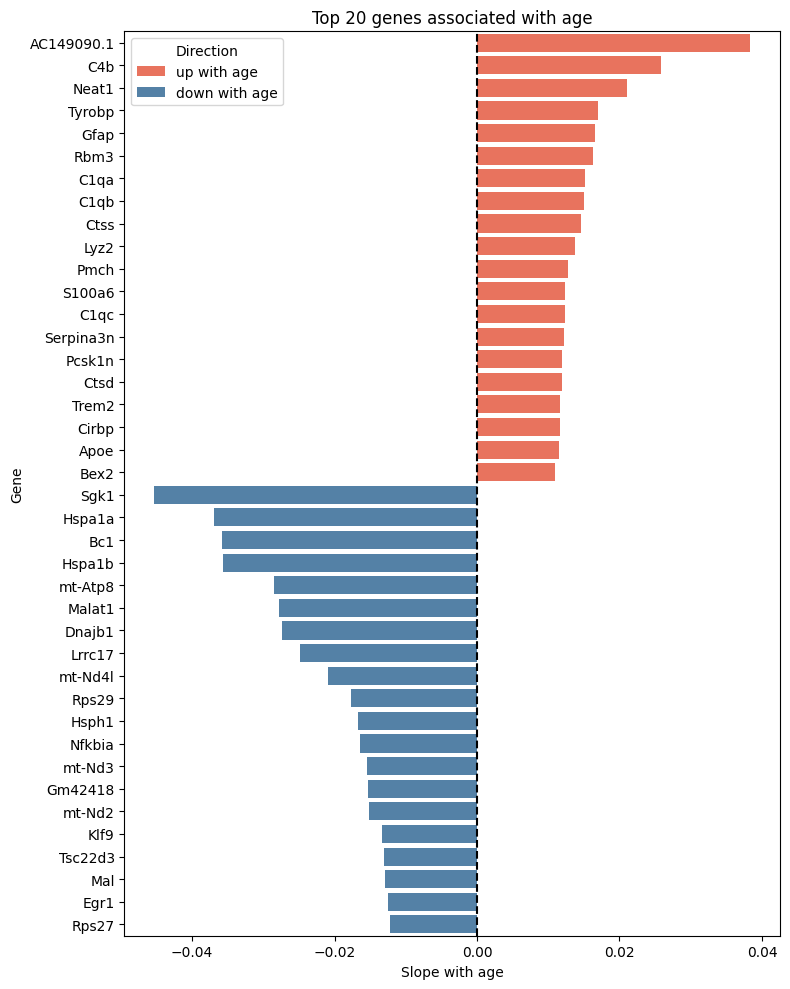

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pick top genes by slope (positive or negative)
top_n = 20
top_pos = res_df.sort_values("slope", ascending=False).head(top_n)
top_neg = res_df.sort_values("slope", ascending=True).head(top_n)

# Combine into one DataFrame for plotting
top_df = pd.concat([top_pos, top_neg])

plt.figure(figsize=(8, 10))
sns.barplot(
    data=top_df,
    y="gene",
    x="slope",
    hue=(top_df["slope"] > 0).map({True: "up with age", False: "down with age"}),
    dodge=False,
    palette={"up with age": "tomato", "down with age": "steelblue"}
)
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Slope with age")
plt.ylabel("Gene")
plt.title(f"Top {top_n} genes associated with age")
plt.legend(title="Direction")
plt.tight_layout()
plt.show()

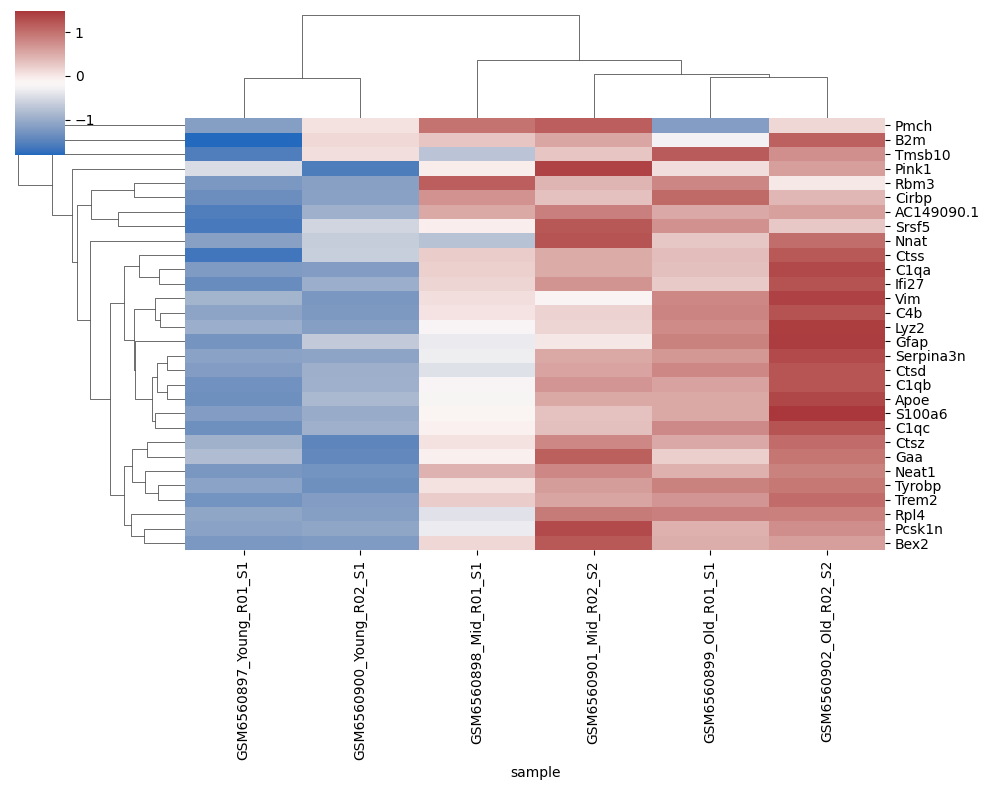

In [43]:
top_genes = res_df.sort_values("slope", ascending=False).head(30)["gene"]
mat = pb[top_genes].T  # genes × samples
mat = mat.loc[top_genes]

sns.clustermap(mat, cmap="vlag", col_cluster=True,
               z_score=0, figsize=(10,8))

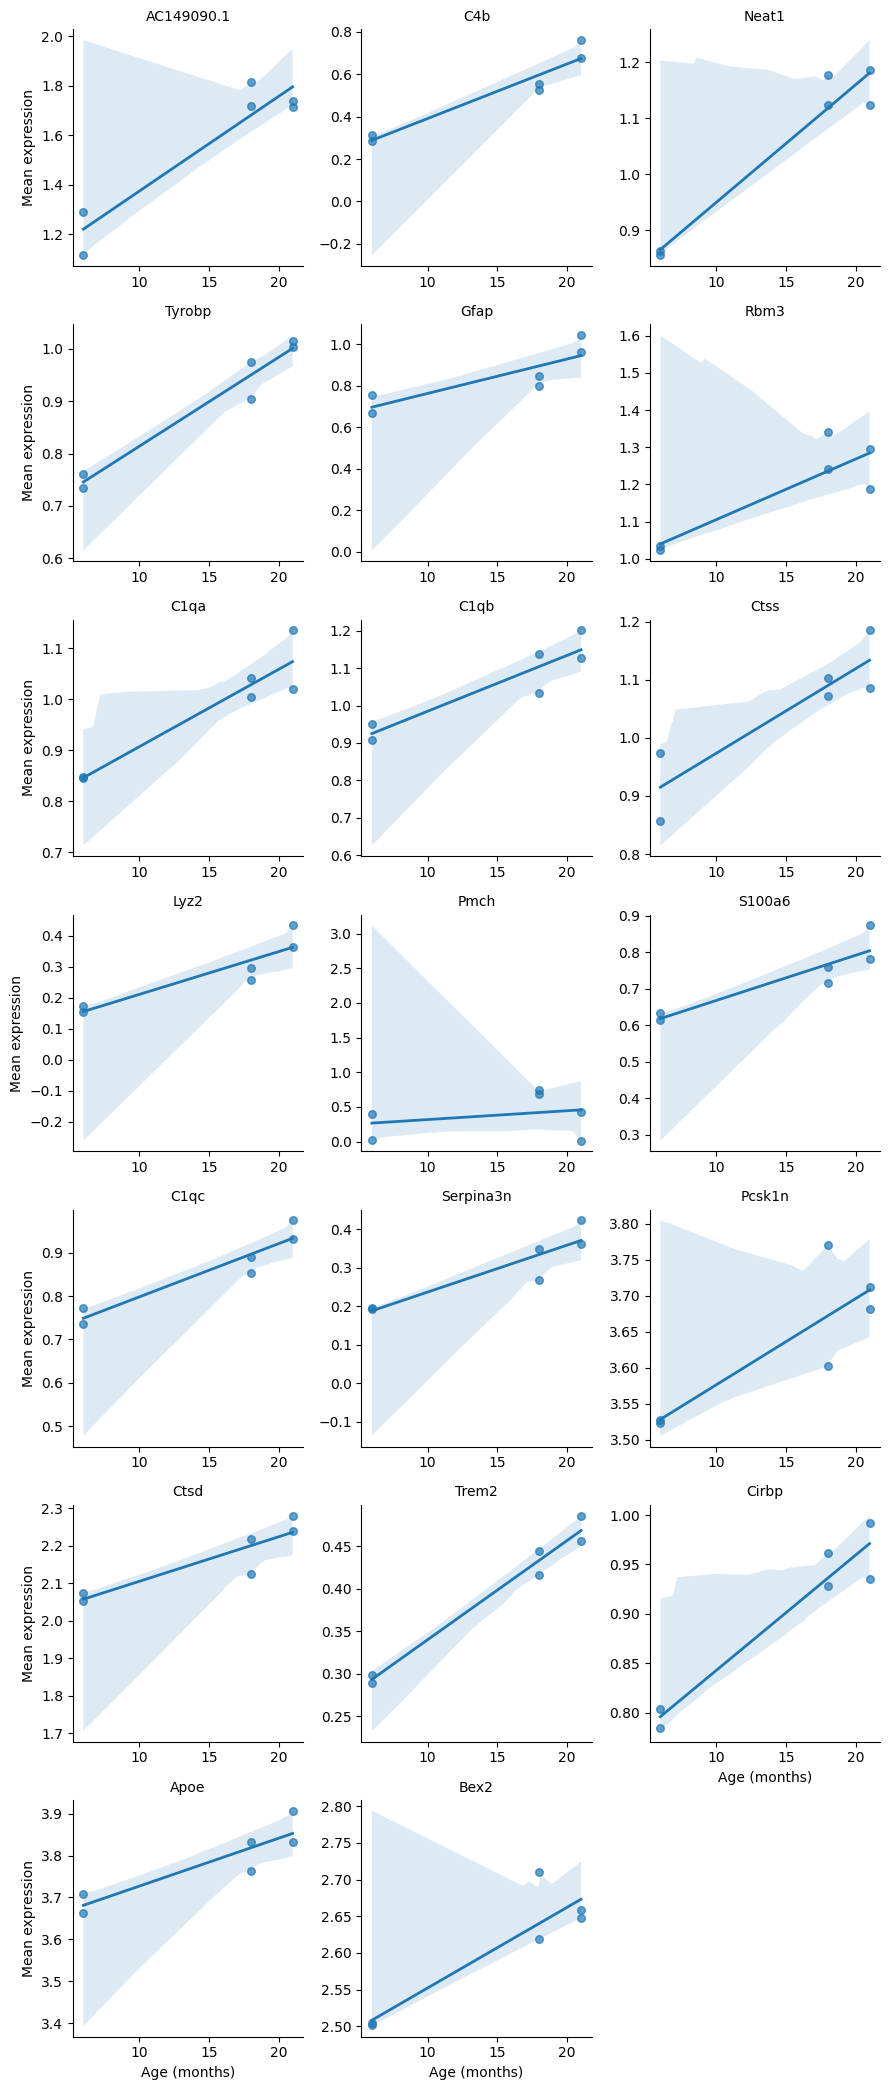

In [44]:

# -- pick top genes by significance (or use slope) --
top_genes = res_df.sort_values("slope", ascending = False).head(20)["gene"]

# Build tidy df: sample-wise mean expression (pseudobulk) + age
pb = adata.to_df().groupby(adata.obs["sample"]).mean()
ages = adata.obs.groupby("sample")["age_months"].first().reindex(pb.index)

# ensure numeric age (fixes the error)
ages = pd.to_numeric(ages, errors="coerce").astype(float)

# gather for selected genes
tidy_list = []
for g in top_genes:
    tidy_list.append(
        pd.DataFrame({
            "sample": pb.index,
            "gene": g,
            "expr": pb[g].astype(float).values,
            "age": ages.values
        })
    )
tidy = pd.concat(tidy_list, ignore_index=True).dropna(subset=["age", "expr"])

# Faceted scatter + linear fit
g = sns.FacetGrid(tidy, col="gene", col_wrap=3, sharex=False, sharey=False, height=3)
g.map_dataframe(sns.regplot, x="age", y="expr", scatter_kws={"s":30, "alpha":0.7}, line_kws={"lw":2})
g.set_axis_labels("Age (months)", "Mean expression")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()